# Carga de librerías

In [3]:
!pip install transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import spacy
import re
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from transformers import pipeline

# Definición de funciones

In [4]:
def normalizeDoc(nlp, doc, nMinCharacters = 4):
    """
    Normaliza un texto eliminando palabras por debajo del mínimo de caracteres, stop words y números.
    Para ello, tokeniza empleando un modelo de Spacy.
    """
    # Separar en tokens
    tokens = nlp(doc)
    # Filtrar tokens
    filtered_tokens = [t.lower_ for t in tokens if (len(t.text) >= nMinCharacters) and not t.is_punct and not re.match('[0-9]+', t.text)]
    # Recombinamos los tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

def obtainSimilarity(doc, docIndex: list[str], vectorizerDict: dict[str]):
    """
    Obtiene la matriz de similitud calculada como la distancia coseno empleando los vectorizadores proporcionados.
    """
    similarityDict = {}
    for tag, vectorizer in vectorizerDict.items():
        vectorizedMatrix = vectorizer.fit_transform(doc)
        vectorizedDf = pd.DataFrame(vectorizedMatrix.toarray(), columns = vectorizer.get_feature_names_out(), index = docIndex)
        similarity = cosine_similarity(vectorizedDf)
        similarityDf = pd.DataFrame(similarity, index = vectorizedDf.index, columns = vectorizedDf.index)
        similarityDict[tag] = similarityDf

    return similarityDict


def findMostSimilar(similarityDict: dict[str, pd.DataFrame], docIndex: list[str], nMostSimilars: int = 1, classes: None | list[str] = None):
    """
    Encuentra el valor más similar para todas las matrices de similitud proporcionadas.
    """
    # Crear df de resultados
    if classes is not None:
        docIndex = list(filter(lambda x: not (x in classes), docIndex))
    mostSimilarDf = pd.DataFrame(index = docIndex, columns = list(similarityDict.keys()))

    for tag, similarity in similarityDict.items():
        
        mostSimilarOptions = []

        for index, row in similarity.iterrows():
            if classes is None:
                # Eliminar la similitud consigo mismo
                rowFiltered = row.drop(index)
            else:
                # Saltar las filas de clases
                if index in classes:
                    continue
                # Seleccionar la similitud con las clases
                rowFiltered = row[classes]
            
            # Buscar la máxima similitud
            mostSimilarIdxs  = rowFiltered.nlargest(nMostSimilars).index.tolist()
            opt  = ', '.join([f"{i} ({rowFiltered[i]:.2f})" for i in mostSimilarIdxs])
            mostSimilarOptions.append(opt)

        # Escribir los resultados
        mostSimilarDf[tag] = mostSimilarOptions
    
    return mostSimilarDf

# Carga del modelo y de archivos

In [5]:
# python -m spacy download es_core_news_lg
nlp = spacy.load("es_core_news_lg")

# Cargar los datos
df = pd.read_csv('data/Distritos_v3.csv')

with open('data/tipologyDescription.json', 'r', encoding = 'utf-8') as f:
    tipology: dict = json.load(f)

# Preprocesado con spacy

In [6]:
# Aplicar preprocesamiento
corpus = df['Información'].tolist()
descriptions = [normalizeDoc(nlp, doc) for doc in corpus]
descriptionIndex = list(df['Zona'].values)

# Clasificación

In [7]:
# Obtener similitud entre barrios
models = {'BoW': CountVectorizer(), 'TF-IDF': TfidfVectorizer(), 'TF-IDF N-gram(1,3)': TfidfVectorizer(ngram_range = (1, 3))}
similarityDict = obtainSimilarity(descriptions, descriptionIndex, models)
mostSimilarBarrioDf = findMostSimilar(similarityDict, descriptionIndex)
mostSimilarBarrioDf

,BoW,TF-IDF,"TF-IDF N-gram(1,3)"
Ciutat Vella,L´Eixample (0.57),L´Eixample (0.35),L´Eixample (0.14)
L´Eixample,Ciutat Vella (0.57),Ciutat Vella (0.35),Ciutat Vella (0.14)
Extramurs,L´Eixample (0.54),L´Eixample (0.33),L´Eixample (0.11)
Campanar,Rascanya (0.36),Rascanya (0.30),Rascanya (0.10)
La Zaidia,El Pla del Real (0.38),L’Olivereta (0.30),Camins al Grau (0.10)
El Pla del Real,Rascanya (0.48),Rascanya (0.34),Rascanya (0.13)
L’Olivereta,Benicalap (0.37),La Zaidia (0.30),Benicalap (0.08)
Patraix,Quatre Carreres (0.46),L´Eixample (0.24),L´Eixample (0.08)
Jesús,La Patacona (Alboraya) (0.36),La Patacona (Alboraya) (0.16),Benicalap (0.05)
Quatre Carreres,L´Eixample (0.54),L´Eixample (0.31),Rascanya (0.11)


In [8]:
# Obtener similitud con clases
classes = list(tipology.keys())
classDescriptions = [normalizeDoc(nlp, doc) for doc in list(tipology.values())]
descriptionsAndClasses = descriptions + classDescriptions
descriptionAndClassesIndex = descriptionIndex + classes

similarityDict = obtainSimilarity(descriptionsAndClasses, descriptionAndClassesIndex, models)
mostSimilarDf = findMostSimilar(similarityDict, descriptionAndClassesIndex, 2, classes)
mostSimilarDf

,BoW,TF-IDF,"TF-IDF N-gram(1,3)"
Ciutat Vella,"suburbano (0.27), histórico (0.22)","suburbano (0.14), histórico (0.12)","suburbano (0.04), histórico (0.03)"
L´Eixample,"suburbano (0.32), comercial (0.27)","suburbano (0.18), turístico (0.14)","suburbano (0.06), universitario (0.05)"
Extramurs,"turístico (0.20), comercial (0.19)","suburbano (0.13), comercial (0.09)","suburbano (0.04), multicultural (0.03)"
Campanar,"familiar (0.11), comercial (0.10)","comercial (0.04), familiar (0.04)","comercial (0.01), suburbano (0.01)"
La Zaidia,"turístico (0.12), comercial (0.12)","comercial (0.05), suburbano (0.05)","comercial (0.01), turístico (0.01)"
El Pla del Real,"suburbano (0.19), familiar (0.10)","suburbano (0.08), familiar (0.07)","suburbano (0.02), familiar (0.02)"
L’Olivereta,"comercial (0.10), suburbano (0.09)","comercial (0.05), lujo (0.04)","comercial (0.01), lujo (0.01)"
Patraix,"suburbano (0.31), familiar (0.23)","suburbano (0.17), familiar (0.14)","suburbano (0.05), familiar (0.04)"
Jesús,"turístico (0.12), comercial (0.12)","turístico (0.06), comercial (0.03)","turístico (0.02), comercial (0.01)"
Quatre Carreres,"suburbano (0.32), familiar (0.19)","suburbano (0.15), familiar (0.09)","suburbano (0.04), familiar (0.03)"


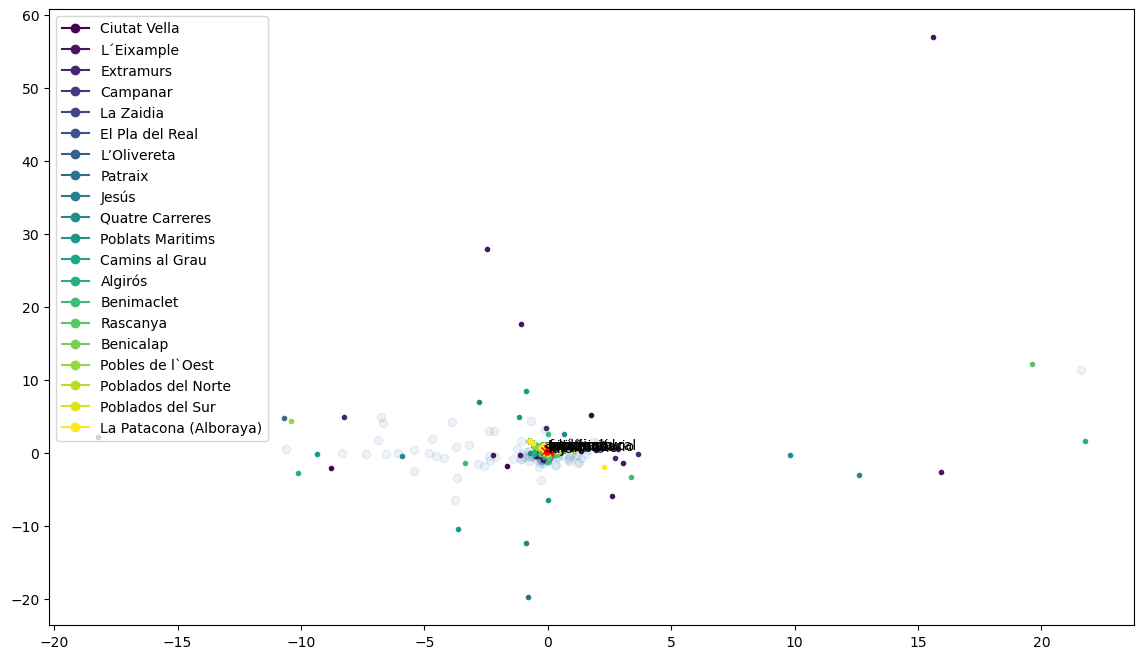

KeyboardInterrupt: 

In [ ]:
# Obtener representación vectorial de lexemas y las palabras de los textos
words = []
for s in descriptions:
    word_list = s.split()
    words.extend(word_list)
lexemas = [nlp.vocab[orth] for orth in nlp.vocab.vectors]
lexemasRand = [t.text for t in np.random.choice(lexemas, 10000, replace = False)]
wordsForTsne = lexemasRand + words + classes
wordVectors = np.array([nlp(word).vector for word in wordsForTsne])

# Obtener embedding a partir de los vectores
tsne = TSNE(n_components = 2, random_state = 0, n_iter = 250, perplexity = 50, init = 'random', learning_rate = 'auto')
np.set_printoptions(suppress = True)
T = tsne.fit_transform(wordVectors)

# Representar lexemas
fig, ax = plt.subplots(figsize = (14, 8))
ax.scatter(T[:len(lexemasRand), 0], T[:len(lexemasRand), 1], c = 'steelblue', alpha = 0.1)

# Representar palabras con color por barrio
cmap = plt.get_cmap('viridis', len(descriptionIndex))

auxIdx = len(lexemasRand)
for i, description in enumerate(descriptions):
    # Filtrar por barrio
    nWords = len([word for word in description.split() if word])
    TFiltered = T[auxIdx:(auxIdx+nWords), :]
    auxIdx += nWords

    ax.plot(TFiltered[:, 0], TFiltered[:, 1], '.', c = cmap(i / len(descriptionIndex)))

# Añadir la leyenda de colores
colorTags = [(tag, cmap(i / len(descriptionIndex))) for i, tag in enumerate(descriptionIndex)]
colorLegend = [plt.Line2D([0], [0], marker = 'o', c = mcolors.to_rgb(color), label = tag) for tag, color in colorTags]
ax.legend(handles = colorLegend, loc = 'best')

# Representar clases
auxIdx = len(lexemasRand) + len(words)
ax.plot(T[auxIdx:, 0], T[auxIdx:, 1], 'x', c = 'red')

for label, x, y in zip(classes, T[auxIdx:, 0], T[auxIdx:, 1]):
    ax.annotate(label, xy = (x, y), xytext = (0, 0), textcoords = 'offset points')

In [9]:
tipology.keys()

dict_keys(['histórico', 'lujo', 'multicultural', 'familiar', 'universitario', 'turístico', 'alternativo', 'suburbano', 'comercial'])

In [10]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to FacebookAI/roberta-large-mnli and revision 130fb28 (https://huggingface.co/FacebookAI/roberta-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [16]:
# Clasificar con modelo de hugging-face
results = []
for doc in descriptions:
    results.append(classifier(
        doc,
        candidate_labels = ['histórico', 'lujo', 'multicultural', 'familiar', 'universitario', 'turístico', 'suburbano', 'comercial']))

# Añadir resultados al df
for barrio, result in zip(descriptionIndex, results):
    mostSimilarDf.loc[barrio, 'zero-shot-classification'] = f"{result['labels'][0]} ({result['scores'][0]:.2f}), {result['labels'][1]} ({result['scores'][1]:.2f})"

mostSimilarDf

,BoW,TF-IDF,"TF-IDF N-gram(1,3)",zero-shot-classification
Ciutat Vella,"suburbano (0.27), histórico (0.22)","suburbano (0.14), histórico (0.12)","suburbano (0.04), histórico (0.03)","turístico (0.22), histórico (0.19)"
L´Eixample,"suburbano (0.32), comercial (0.27)","suburbano (0.18), turístico (0.14)","suburbano (0.06), universitario (0.05)","multicultural (0.16), familiar (0.16)"
Extramurs,"turístico (0.20), comercial (0.19)","suburbano (0.13), comercial (0.09)","suburbano (0.04), multicultural (0.03)","familiar (0.22), histórico (0.17)"
Campanar,"familiar (0.11), comercial (0.10)","comercial (0.04), familiar (0.04)","comercial (0.01), suburbano (0.01)","comercial (0.28), suburbano (0.19)"
La Zaidia,"turístico (0.12), comercial (0.12)","comercial (0.05), suburbano (0.05)","comercial (0.01), turístico (0.01)","familiar (0.28), multicultural (0.24)"
El Pla del Real,"suburbano (0.19), familiar (0.10)","suburbano (0.08), familiar (0.07)","suburbano (0.02), familiar (0.02)","histórico (0.29), multicultural (0.17)"
L’Olivereta,"comercial (0.10), suburbano (0.09)","comercial (0.05), lujo (0.04)","comercial (0.01), lujo (0.01)","turístico (0.24), multicultural (0.23)"
Patraix,"suburbano (0.31), familiar (0.23)","suburbano (0.17), familiar (0.14)","suburbano (0.05), familiar (0.04)","multicultural (0.24), comercial (0.17)"
Jesús,"turístico (0.12), comercial (0.12)","turístico (0.06), comercial (0.03)","turístico (0.02), comercial (0.01)","multicultural (0.24), familiar (0.20)"
Quatre Carreres,"suburbano (0.32), familiar (0.19)","suburbano (0.15), familiar (0.09)","suburbano (0.04), familiar (0.03)","comercial (0.23), familiar (0.15)"


Ciutat Vella, Extramurs, Campanar, Patraix, Jesús, Benimaclet (mejor si fuera universitario), Benicalap

In [17]:
# Mostrar mostSimilarDf solo para 'Ciutat Vella', 'Extramurs', 'Patraix', 'Jesús', 'Benimaclet', 'Benicalap' solo la columna 'zero-shot-classification'

mostSimilarDf.loc[['Ciutat Vella', 'Extramurs', 'Patraix', 'Jesús', 'Benimaclet', 'Benicalap'], ['zero-shot-classification']]

,zero-shot-classification
Ciutat Vella,"turístico (0.22), histórico (0.19)"
Extramurs,"familiar (0.22), histórico (0.17)"
Patraix,"multicultural (0.24), comercial (0.17)"
Jesús,"multicultural (0.24), familiar (0.20)"
Benimaclet,"multicultural (0.18), familiar (0.16)"
Benicalap,"suburbano (0.19), familiar (0.17)"


### Cambiamos número de clases a las que hemos elegido viendo lo de arriba

In [12]:
# Obtener similitud entre barrios
models = {'BoW': CountVectorizer(), 'TF-IDF': TfidfVectorizer(), 'TF-IDF N-gram(1,3)': TfidfVectorizer(ngram_range = (1, 3))}
similarityDict = obtainSimilarity(descriptions, descriptionIndex, models)
mostSimilarBarrioDf = findMostSimilar(similarityDict, descriptionIndex)
mostSimilarBarrioDf

,BoW,TF-IDF,"TF-IDF N-gram(1,3)"
Ciutat Vella,L´Eixample (0.57),L´Eixample (0.35),L´Eixample (0.14)
L´Eixample,Ciutat Vella (0.57),Ciutat Vella (0.35),Ciutat Vella (0.14)
Extramurs,L´Eixample (0.54),L´Eixample (0.33),L´Eixample (0.11)
Campanar,Rascanya (0.36),Rascanya (0.30),Rascanya (0.10)
La Zaidia,El Pla del Real (0.38),L’Olivereta (0.30),Camins al Grau (0.10)
El Pla del Real,Rascanya (0.48),Rascanya (0.34),Rascanya (0.13)
L’Olivereta,Benicalap (0.37),La Zaidia (0.30),Benicalap (0.08)
Patraix,Quatre Carreres (0.46),L´Eixample (0.24),L´Eixample (0.08)
Jesús,La Patacona (Alboraya) (0.36),La Patacona (Alboraya) (0.16),Benicalap (0.05)
Quatre Carreres,L´Eixample (0.54),L´Eixample (0.31),Rascanya (0.11)


In [13]:
# Obtener similitud con clases
classes = list(tipology.keys())
classDescriptions = [normalizeDoc(nlp, doc) for doc in list(tipology.values())]
descriptionsAndClasses = descriptions + classDescriptions
descriptionAndClassesIndex = descriptionIndex + classes

similarityDict = obtainSimilarity(descriptionsAndClasses, descriptionAndClassesIndex, models)
mostSimilarDf = findMostSimilar(similarityDict, descriptionAndClassesIndex, 2, classes)
mostSimilarDf

,BoW,TF-IDF,"TF-IDF N-gram(1,3)"
Ciutat Vella,"suburbano (0.27), histórico (0.22)","suburbano (0.14), histórico (0.12)","suburbano (0.04), histórico (0.03)"
L´Eixample,"suburbano (0.32), comercial (0.27)","suburbano (0.18), turístico (0.14)","suburbano (0.06), universitario (0.05)"
Extramurs,"turístico (0.20), comercial (0.19)","suburbano (0.13), comercial (0.09)","suburbano (0.04), multicultural (0.03)"
Campanar,"familiar (0.11), comercial (0.10)","comercial (0.04), familiar (0.04)","comercial (0.01), suburbano (0.01)"
La Zaidia,"turístico (0.12), comercial (0.12)","comercial (0.05), suburbano (0.05)","comercial (0.01), turístico (0.01)"
El Pla del Real,"suburbano (0.19), familiar (0.10)","suburbano (0.08), familiar (0.07)","suburbano (0.02), familiar (0.02)"
L’Olivereta,"comercial (0.10), suburbano (0.09)","comercial (0.05), lujo (0.04)","comercial (0.01), lujo (0.01)"
Patraix,"suburbano (0.31), familiar (0.23)","suburbano (0.17), familiar (0.14)","suburbano (0.05), familiar (0.04)"
Jesús,"turístico (0.12), comercial (0.12)","turístico (0.06), comercial (0.03)","turístico (0.02), comercial (0.01)"
Quatre Carreres,"suburbano (0.32), familiar (0.19)","suburbano (0.15), familiar (0.09)","suburbano (0.04), familiar (0.03)"


In [14]:
# Clasificar con modelo de hugging-face
results = []
for doc in descriptions:
    results.append(classifier(
        doc,
        candidate_labels = ['histórico', 'multicultural', 'familiar', 'turístico',  'comercial']))

# Añadir resultados al df
for barrio, result in zip(descriptionIndex, results):
    mostSimilarDf.loc[barrio, 'zero-shot-classification'] = f"{result['labels'][0]} ({result['scores'][0]:.2f}), {result['labels'][1]} ({result['scores'][1]:.2f})"

mostSimilarDf

,BoW,TF-IDF,"TF-IDF N-gram(1,3)",zero-shot-classification
Ciutat Vella,"suburbano (0.27), histórico (0.22)","suburbano (0.14), histórico (0.12)","suburbano (0.04), histórico (0.03)","turístico (0.29), histórico (0.25)"
L´Eixample,"suburbano (0.32), comercial (0.27)","suburbano (0.18), turístico (0.14)","suburbano (0.06), universitario (0.05)","multicultural (0.22), familiar (0.22)"
Extramurs,"turístico (0.20), comercial (0.19)","suburbano (0.13), comercial (0.09)","suburbano (0.04), multicultural (0.03)","familiar (0.30), histórico (0.24)"
Campanar,"familiar (0.11), comercial (0.10)","comercial (0.04), familiar (0.04)","comercial (0.01), suburbano (0.01)","comercial (0.41), multicultural (0.20)"
La Zaidia,"turístico (0.12), comercial (0.12)","comercial (0.05), suburbano (0.05)","comercial (0.01), turístico (0.01)","familiar (0.32), multicultural (0.27)"
El Pla del Real,"suburbano (0.19), familiar (0.10)","suburbano (0.08), familiar (0.07)","suburbano (0.02), familiar (0.02)","histórico (0.37), multicultural (0.22)"
L’Olivereta,"comercial (0.10), suburbano (0.09)","comercial (0.05), lujo (0.04)","comercial (0.01), lujo (0.01)","turístico (0.35), multicultural (0.35)"
Patraix,"suburbano (0.31), familiar (0.23)","suburbano (0.17), familiar (0.14)","suburbano (0.05), familiar (0.04)","multicultural (0.32), comercial (0.23)"
Jesús,"turístico (0.12), comercial (0.12)","turístico (0.06), comercial (0.03)","turístico (0.02), comercial (0.01)","multicultural (0.32), familiar (0.27)"
Quatre Carreres,"suburbano (0.32), familiar (0.19)","suburbano (0.15), familiar (0.09)","suburbano (0.04), familiar (0.03)","comercial (0.32), familiar (0.21)"


In [15]:
# Exportar a csv llamado 'mostSimilarDf_5zero.csv'

mostSimilarDf.to_csv('./data/mostSimilarDf_5zero.csv')

## Incorporación de más opiniones (InsideAirbnb)

In [16]:
# Coger dataframe de './data/insideListings.csv'

detailedListings = pd.read_csv('data/insideListings.csv')

In [17]:
detailedListings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,language
0,26405420,https://www.airbnb.com/rooms/26405420,20240324214747,2024-03-24,city scrape,Ca María,2mts from the beach. Jacuzzi terrace A<br /><b...,It is a very quiet and residential neighborhoo...,https://a0.muscache.com/pictures/fbb3dfe2-d1f0...,198185545,...,4.75,4.67,vt-46858 v,f,2,2,0,0,1.83,en
1,1110191981989532950,https://www.airbnb.com/rooms/1110191981989532950,20240324214747,2024-03-25,city scrape,Feliz casa!,"2 km to city center, good transportation, supe...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,312158352,...,NaN,NaN,NaN,t,1,0,0,1,NaN,unknown
2,970202040703865678,https://www.airbnb.com/rooms/970202040703865678,20240324214747,2024-03-25,city scrape,apartamento completo 4,The apartment does not have a kitchen and does...,NaN,https://a0.muscache.com/pictures/4457bfe1-47da...,474489305,...,NaN,NaN,NaN,f,24,4,20,0,NaN,unknown
3,1110200636787207468,https://www.airbnb.com/rooms/1110200636787207468,20240324214747,2024-03-25,city scrape,Eco Suite mediterránea,Forget the worries in this great home - it's a...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,425428991,...,NaN,NaN,NaN,t,10,10,0,0,NaN,unknown
4,1093325332010686347,https://www.airbnb.com/rooms/1093325332010686347,20240324214747,2024-03-25,previous scrape,Apartment close to the Turia,Enjoy a stylish experience at this centrally-l...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,287097266,...,NaN,NaN,NaN,f,1,1,0,0,NaN,unknown


In [18]:
# Agrupar opiniones por distrito. Las opiniones están en la columna 'neighborhood_overview', los distritos en 'neighbourhood_group_cleansed'. Quiero solo las de language = "es" además

listingsNeighborhoodES = detailedListings[detailedListings['language'] == 'es'].groupby('neighbourhood_group_cleansed')

# coger solo la columna 'id', 'neighborhood_overview' y 'neighbourhood_group_cleansed'

listingsNeighborhoodES = listingsNeighborhoodES[['neighborhood_overview']].agg(lambda x: x.tolist())


In [19]:
listingsNeighborhoodES.head()

,neighborhood_overview
neighbourhood_group_cleansed,
ALGIROS,[El barrio Pla del Real es uno de los mejores ...
BENICALAP,"[Barrio muy seguro, Es un barrio tranquilo c..."
BENIMACLET,"[""Benimaclet"", este barrio es considerado un b..."
CAMINS AL GRAU,[UBICADO Entre las Av. del Puerto y de Francia...
CAMPANAR,[El alojamiento Está Rodeado de Naturaleza. Ti...


In [20]:
# Sacar número elementos cada distrito

listingsNeighborhoodES['count'] = listingsNeighborhoodES['neighborhood_overview'].apply(lambda x: len(x))
listingsNeighborhoodES.head()

,neighborhood_overview,count
neighbourhood_group_cleansed,,
ALGIROS,[El barrio Pla del Real es uno de los mejores ...,90
BENICALAP,"[Barrio muy seguro, Es un barrio tranquilo c...",66
BENIMACLET,"[""Benimaclet"", este barrio es considerado un b...",36
CAMINS AL GRAU,[UBICADO Entre las Av. del Puerto y de Francia...,187
CAMPANAR,[El alojamiento Está Rodeado de Naturaleza. Ti...,39


In [21]:
# preprocesar las opiniones

descriptionsInside = listingsNeighborhoodES['neighborhood_overview'].apply(lambda x: [normalizeDoc(nlp, doc) for doc in x]) 
descriptionIndexInside = list(listingsNeighborhoodES.index)

In [22]:
combined_opinions = [" ".join(opinions) for opinions in descriptionsInside]

In [23]:
similarityDictInside = obtainSimilarity(combined_opinions, descriptionIndexInside, models)
mostSimilarBarrioDfInside = findMostSimilar(similarityDictInside, descriptionIndexInside)
mostSimilarBarrioDfInside

,BoW,TF-IDF,"TF-IDF N-gram(1,3)"
ALGIROS,CAMINS AL GRAU (0.87),CAMINS AL GRAU (0.75),CAMINS AL GRAU (0.40)
BENICALAP,RASCANYA (0.62),L'OLIVERETA (0.49),L'OLIVERETA (0.14)
BENIMACLET,RASCANYA (0.80),RASCANYA (0.68),RASCANYA (0.31)
CAMINS AL GRAU,ALGIROS (0.87),ALGIROS (0.75),POBLATS MARITIMS (0.42)
CAMPANAR,EL PLA DEL REAL (0.81),L'OLIVERETA (0.65),CAMINS AL GRAU (0.31)
CIUTAT VELLA,EXTRAMURS (0.87),EXTRAMURS (0.78),EXTRAMURS (0.56)
EL PLA DEL REAL,CAMINS AL GRAU (0.85),ALGIROS (0.70),CAMINS AL GRAU (0.34)
EXTRAMURS,PATRAIX (0.89),CIUTAT VELLA (0.78),CIUTAT VELLA (0.56)
JESUS,PATRAIX (0.90),PATRAIX (0.82),PATRAIX (0.61)
L'EIXAMPLE,QUATRE CARRERES (0.83),QUATRE CARRERES (0.69),QUATRE CARRERES (0.41)


In [25]:
# Obtener similitud con clases
descriptionsAndClassesInside = combined_opinions + classDescriptions
descriptionsAndClassesIndexInside = descriptionIndexInside + classes

similarityDictInside = obtainSimilarity(descriptionsAndClassesInside, descriptionsAndClassesIndexInside, models)
mostSimilarDfInside = findMostSimilar(similarityDictInside, descriptionsAndClassesIndexInside, 2, classes)
mostSimilarDfInside

,BoW,TF-IDF,"TF-IDF N-gram(1,3)"
ALGIROS,"suburbano (0.27), turístico (0.23)","suburbano (0.15), universitario (0.13)","suburbano (0.05), universitario (0.04)"
BENICALAP,"suburbano (0.20), comercial (0.13)","suburbano (0.11), comercial (0.07)","suburbano (0.02), comercial (0.01)"
BENIMACLET,"suburbano (0.20), comercial (0.20)","universitario (0.11), turístico (0.10)","suburbano (0.03), turístico (0.03)"
CAMINS AL GRAU,"suburbano (0.33), comercial (0.25)","suburbano (0.19), comercial (0.14)","suburbano (0.06), comercial (0.05)"
CAMPANAR,"suburbano (0.26), comercial (0.20)","suburbano (0.15), comercial (0.13)","comercial (0.04), suburbano (0.04)"
CIUTAT VELLA,"suburbano (0.33), turístico (0.23)","suburbano (0.19), turístico (0.14)","suburbano (0.06), turístico (0.05)"
EL PLA DEL REAL,"suburbano (0.27), comercial (0.20)","suburbano (0.15), comercial (0.10)","suburbano (0.04), comercial (0.03)"
EXTRAMURS,"suburbano (0.32), comercial (0.24)","suburbano (0.19), comercial (0.13)","suburbano (0.06), comercial (0.04)"
JESUS,"suburbano (0.26), histórico (0.23)","suburbano (0.14), histórico (0.11)","suburbano (0.04), histórico (0.03)"
L'EIXAMPLE,"suburbano (0.27), turístico (0.25)","suburbano (0.14), comercial (0.14)","alternativo (0.06), comercial (0.05)"


In [76]:
# Clasificar con modelo de hugging-face
resultsInside = []
for doc in combined_opinions:
    resultsInside.append(classifier(
        doc,
        candidate_labels = ['histórico', 'lujo', 'multicultural', 'familiar', 'universitario', 'turístico', 'suburbano', 'comercial']))
    
# Añadir resultados al df
for barrio, result in zip(descriptionIndexInside, resultsInside):
    mostSimilarDfInside.loc[barrio, 'zero-shot-classification'] = f"{result['labels'][0]} ({result['scores'][0]:.2f}), {result['labels'][1]} ({result['scores'][1]:.2f})"
    
mostSimilarDfInside

,BoW,TF-IDF,"TF-IDF N-gram(1,3)",zero-shot-classification
ALGIROS,"suburbano (0.27), turístico (0.23)","suburbano (0.15), universitario (0.13)","suburbano (0.05), universitario (0.04)","multicultural (0.21), familiar (0.14)"
BENICALAP,"suburbano (0.20), comercial (0.13)","suburbano (0.11), comercial (0.07)","suburbano (0.02), comercial (0.01)","histórico (0.18), familiar (0.15)"
BENIMACLET,"suburbano (0.20), comercial (0.20)","universitario (0.11), suburbano (0.10)","suburbano (0.03), universitario (0.03)","multicultural (0.27), familiar (0.18)"
CAMINS AL GRAU,"suburbano (0.33), comercial (0.25)","suburbano (0.19), comercial (0.14)","suburbano (0.06), comercial (0.05)","turístico (0.19), histórico (0.14)"
CAMPANAR,"suburbano (0.26), comercial (0.20)","suburbano (0.15), comercial (0.13)","comercial (0.04), suburbano (0.04)","histórico (0.23), comercial (0.14)"
CIUTAT VELLA,"suburbano (0.33), turístico (0.23)","suburbano (0.19), turístico (0.14)","suburbano (0.06), turístico (0.05)","turístico (0.21), lujo (0.19)"
EL PLA DEL REAL,"suburbano (0.27), comercial (0.20)","suburbano (0.15), comercial (0.10)","suburbano (0.04), comercial (0.03)","turístico (0.25), histórico (0.19)"
EXTRAMURS,"suburbano (0.32), comercial (0.24)","suburbano (0.19), comercial (0.13)","suburbano (0.06), comercial (0.04)","familiar (0.19), multicultural (0.15)"
JESUS,"suburbano (0.26), histórico (0.23)","suburbano (0.14), histórico (0.11)","suburbano (0.04), histórico (0.03)","familiar (0.29), histórico (0.13)"
L'EIXAMPLE,"suburbano (0.27), turístico (0.25)","suburbano (0.14), comercial (0.14)","alternativo (0.06), suburbano (0.05)","histórico (0.16), multicultural (0.14)"


Vemos que suburbano abunda muchísimo.

In [26]:
# Repetir todo pero quitando 'suburbano' de las clases

classesFiltered = [cls for cls in classes if cls != 'suburbano']
classDescriptionsFiltered = [normalizeDoc(nlp, tipology[cls]) for cls in classesFiltered]
descriptionsAndClassesFiltered = combined_opinions + classDescriptionsFiltered
descriptionsAndClassesIndexFiltered = descriptionIndexInside + classesFiltered

In [27]:
# Obtener similitud con clases
similarityDictFiltered = obtainSimilarity(descriptionsAndClassesFiltered, descriptionsAndClassesIndexFiltered, models)
mostSimilarDfFiltered = findMostSimilar(similarityDictFiltered, descriptionsAndClassesIndexFiltered, 2, classesFiltered)
mostSimilarDfFiltered

,BoW,TF-IDF,"TF-IDF N-gram(1,3)"
ALGIROS,"turístico (0.23), comercial (0.22)","universitario (0.13), turístico (0.12)","universitario (0.04), turístico (0.04)"
BENICALAP,"comercial (0.13), turístico (0.10)","comercial (0.07), turístico (0.05)","comercial (0.01), multicultural (0.01)"
BENIMACLET,"comercial (0.20), universitario (0.20)","universitario (0.11), turístico (0.10)","universitario (0.03), turístico (0.03)"
CAMINS AL GRAU,"comercial (0.25), turístico (0.21)","comercial (0.14), turístico (0.11)","comercial (0.05), turístico (0.04)"
CAMPANAR,"comercial (0.20), turístico (0.13)","comercial (0.13), turístico (0.06)","comercial (0.04), suburbano2 (0.02)"
CIUTAT VELLA,"turístico (0.23), comercial (0.23)","turístico (0.14), comercial (0.13)","turístico (0.05), comercial (0.05)"
EL PLA DEL REAL,"comercial (0.20), turístico (0.17)","comercial (0.11), turístico (0.09)","comercial (0.03), turístico (0.03)"
EXTRAMURS,"comercial (0.24), turístico (0.22)","comercial (0.13), turístico (0.12)","comercial (0.04), turístico (0.04)"
JESUS,"histórico (0.23), turístico (0.19)","histórico (0.11), turístico (0.10)","histórico (0.03), turístico (0.03)"
L'EIXAMPLE,"turístico (0.25), comercial (0.25)","comercial (0.14), turístico (0.13)","alternativo (0.06), comercial (0.05)"


In [31]:
# Clasificar con modelo de hugging-face
resultsFiltered = []
for doc in combined_opinions:
    resultsFiltered.append(classifier(
        doc,
        candidate_labels = ['histórico', 'lujo', 'multicultural', 'familiar', 'universitario', 'turístico', 'comercial', 'suburbano2']))
    
# Añadir resultados al df
for barrio, result in zip(descriptionIndexInside, resultsFiltered):
    mostSimilarDfFiltered.loc[barrio, 'zero-shot-classification'] = f"{result['labels'][0]} ({result['scores'][0]:.2f}), {result['labels'][1]} ({result['scores'][1]:.2f})"
    
mostSimilarDfFiltered

,BoW,TF-IDF,"TF-IDF N-gram(1,3)",zero-shot-classification
ALGIROS,"turístico (0.23), comercial (0.22)","universitario (0.13), turístico (0.12)","universitario (0.04), turístico (0.04)","multicultural (0.22), familiar (0.15)"
BENICALAP,"comercial (0.13), turístico (0.10)","comercial (0.07), turístico (0.05)","comercial (0.01), multicultural (0.01)","histórico (0.18), familiar (0.15)"
BENIMACLET,"comercial (0.20), universitario (0.20)","universitario (0.11), turístico (0.10)","universitario (0.03), turístico (0.03)","multicultural (0.28), familiar (0.18)"
CAMINS AL GRAU,"comercial (0.25), turístico (0.21)","comercial (0.14), turístico (0.11)","comercial (0.05), turístico (0.04)","turístico (0.19), histórico (0.14)"
CAMPANAR,"comercial (0.20), turístico (0.13)","comercial (0.13), turístico (0.06)","comercial (0.04), suburbano2 (0.02)","histórico (0.24), comercial (0.14)"
CIUTAT VELLA,"turístico (0.23), comercial (0.23)","turístico (0.14), comercial (0.13)","turístico (0.05), comercial (0.05)","turístico (0.21), lujo (0.19)"
EL PLA DEL REAL,"comercial (0.20), turístico (0.17)","comercial (0.11), turístico (0.09)","comercial (0.03), turístico (0.03)","turístico (0.25), histórico (0.19)"
EXTRAMURS,"comercial (0.24), turístico (0.22)","comercial (0.13), turístico (0.12)","comercial (0.04), turístico (0.04)","familiar (0.19), multicultural (0.15)"
JESUS,"histórico (0.23), turístico (0.19)","histórico (0.11), turístico (0.10)","histórico (0.03), turístico (0.03)","familiar (0.30), histórico (0.13)"
L'EIXAMPLE,"turístico (0.25), comercial (0.25)","comercial (0.14), turístico (0.13)","alternativo (0.06), comercial (0.05)","histórico (0.17), multicultural (0.14)"


Recojo en una función lo de quitar clases para que se agilice la visualización de las tablas.

In [92]:
classes

['histórico',
 'lujo',
 'multicultural',
 'familiar',
 'universitario',
 'turístico',
 'alternativo',
 'suburbano',
 'comercial']

In [91]:
def process_opinions_with_filter(classes_to_remove, combined_opinions, descriptionIndexInside, models, classifier, tipology, nlp):
    """
    Procesa las opiniones de los barrios filtrando las clases que se quieren eliminar.
    """
    # Filtrar las clases y las descripciones correspondientes
    classesFiltered = [cls for cls in classes if cls not in classes_to_remove]
    classDescriptionsFiltered = [normalizeDoc(nlp, tipology[cls]) for cls in classesFiltered]

    # Combinar opiniones y descripciones filtradas
    descriptionsAndClassesFiltered = combined_opinions + classDescriptionsFiltered
    descriptionsAndClassesIndexFiltered = descriptionIndexInside + classesFiltered

    # Obtener similitud con clases
    similarityDictFiltered = obtainSimilarity(descriptionsAndClassesFiltered, descriptionsAndClassesIndexFiltered, models)
    mostSimilarDfFiltered = findMostSimilar(similarityDictFiltered, descriptionsAndClassesIndexFiltered, 2, classesFiltered)

    # Clasificar con modelo de hugging-face
    resultsFiltered = []
    for doc in combined_opinions:
        resultsFiltered.append(classifier(
            doc,
            candidate_labels = classesFiltered))

    # Añadir resultados al dataframe
    for barrio, result in zip(descriptionIndexInside, resultsFiltered):
        mostSimilarDfFiltered.loc[barrio, 'zero-shot-classification'] = ", ".join([f"{label} ({score:.2f})" for label, score in zip(result['labels'], result['scores'])])

    return mostSimilarDfFiltered

# Uso de la función
classes_to_remove = ['suburbano']
filtered_results = process_opinions_with_filter(classes_to_remove, combined_opinions, descriptionIndexInside, models, classifier, tipology, nlp)
filtered_results


,BoW,TF-IDF,"TF-IDF N-gram(1,3)",zero-shot-classification
ALGIROS,"turístico (0.23), comercial (0.22)","universitario (0.13), turístico (0.12)","universitario (0.04), turístico (0.04)","multicultural (0.21), familiar (0.14), comerci..."
BENICALAP,"comercial (0.13), turístico (0.10)","comercial (0.07), turístico (0.05)","comercial (0.01), multicultural (0.01)","histórico (0.17), familiar (0.15), comercial (..."
BENIMACLET,"comercial (0.20), universitario (0.20)","universitario (0.11), turístico (0.10)","universitario (0.03), turístico (0.03)","multicultural (0.27), familiar (0.18), univers..."
CAMINS AL GRAU,"comercial (0.25), turístico (0.21)","comercial (0.14), turístico (0.11)","comercial (0.05), turístico (0.04)","turístico (0.18), alternativo (0.13), históric..."
CAMPANAR,"comercial (0.20), turístico (0.13)","comercial (0.13), turístico (0.06)","comercial (0.04), turístico (0.02)","histórico (0.23), comercial (0.13), turístico ..."
CIUTAT VELLA,"turístico (0.23), comercial (0.23)","turístico (0.14), comercial (0.13)","turístico (0.05), comercial (0.05)","turístico (0.20), lujo (0.18), histórico (0.17..."
EL PLA DEL REAL,"comercial (0.20), turístico (0.17)","comercial (0.11), turístico (0.09)","comercial (0.03), turístico (0.02)","turístico (0.24), histórico (0.18), multicultu..."
EXTRAMURS,"comercial (0.24), turístico (0.22)","comercial (0.13), turístico (0.12)","comercial (0.04), turístico (0.04)","familiar (0.18), multicultural (0.14), turísti..."
JESUS,"histórico (0.23), turístico (0.19)","histórico (0.11), turístico (0.10)","histórico (0.03), turístico (0.03)","familiar (0.29), histórico (0.12), multicultur..."
L'EIXAMPLE,"turístico (0.25), comercial (0.25)","comercial (0.14), turístico (0.13)","alternativo (0.06), comercial (0.05)","histórico (0.16), multicultural (0.14), altern..."


In [ ]:
dfToExport = mostSimilarDf.rename(
    index = {
        'L´Eixample': "L'Eixample",
        'L’Olivereta': "L'Olivereta",
        'Jesús': 'Jesus',
        'Algirós': 'Algiros',
        'Pobles de l`Oest': "POBLATS DE L'OEST",
        'Poblados del Norte': 'POBLATS DEL NORD',
        'Poblados del Sur': 'POBLATS DEL SUD',
        'La Zaidia': 'La Saidia'
        })
dfToExport.to_csv('data/distritosClasificacion.csv', sep = ';')